# Predicting the diagnosis of heart diseases

## Introduction

Heart disease includes a number of conditions affecting the cardiovascular system. Some of the typical conditions include blood vessel obstruction by fatty plaque, arrhythmic heartbeat, and heart valve failures (Mayo Clinic, 2021). Heart disease conditions have been studied extensively and a number of risk factors have been identified. These risk factors include patients’ age, sex, presence of chest pain, serum cholesterol level, etc (Mayo Clinic, 2021). The Cleveland database included 76 such attributes associated with heart disease patients. The literature on heart disease favoured 14 of these attributes which we used a subset of them for this project.

For this project, our goal is to predict patients’ heart disease status (presence) given patients’ characteristics and symptoms found in the Cleveland database. Our predictive question: Can we create a model with better than random chance (>50%) to predict the presence of heart disease to be used as an early indicator?

This dataset is processed from a database of 76 recorded attributes of a patient, only 14 of which are used in published experiments. The Cleveland dataset attempts to predict the diagnosis of heart disaease in a patient using 13 predictors (14 attributes): age, sex, chest pain type, resting blood pressure, cholestoral level, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, slope of peak exercise ST segment, number of major vessels colored by fluoroscopy, and thalassemia range. For our model, we will only be using the predictors age, cholesterol level, maximum heart rate achieved, resting blood pressure, and number of major vessels colored by fluoroscopy. We will elaborate on why we decided to only use these predictors.

## Methods and Results

### Overview
We first decided to eliminate predictors that are categorical as opposed to quantitative as they would not work with a K-nearest neighbour model. We also eliminated predictors with missing data. This eliminated the predictors sex, chest pain type, fasting blood sugar, resting electrocardiographic results, exercise induced angina ST depression induced by exercise relative to rest, slope of peak exercise ST segment, and thalassemia range. We then mutated the heart disease diagnosis attribute to only include yes/no for a heart diagnosis as we are not interested in severity from a scale of 0-4 (0 is no and 1-4 is yes). We did this as for the purposes of our model (to be used as an early indicator of heart disease), we believe it is important to treat every possible severity of heart disease with the same weight to encourage the patient to see a medical professional regardless of severity. We used a k-nearest neighbour classification model. We created a recipe that will predict the status of heart disease diagnosis using the predictors we have not eliminated. We cross-validated our training data to find the best value of k, and created a workflow with the recipe and model containing the ideal value of k. Finally, we used this model to predict our testing data and determine the accuracy of our model using a confusion matrix.

### Procedure
We began by setting the seed and importing the libraries tidyverse, tidymodels, and GGally.

In [75]:
# Set the seed to ensure reproducibility
set.seed(0)
library(tidyverse) 
library(tidymodels)
library(GGally)

options(repr.matrix.max.rows = 6)

We read the Cleveland heart disease data set from the source database, removed missing values, and added categorization for pressence of heart disease.

We set hd to yes/no instead of 0-4. We believe that if the patient has any indication of heart disease, it should be treated with the same severity as a concrete indication of heart disease in order to increase the chances of a positive outcome.

In [76]:
# Read the data set into R from source
col_names <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# Clean and wrangle data, remove missing values
heart_disease <- read_csv(url, col_names=col_names) %>%
    filter(thal != "?") %>%
    filter(ca != "?") %>%
    mutate(hd = ifelse(num > 0, "Yes", "No")) %>% #recode heart disease status into presence and non-presence
    mutate(hd = as_factor(hd), ca = as.double(ca), thal = as.double(thal))
heart_disease 


Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2,Yes
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1,Yes


Table 1: Subset of the heart disease data set

We split the data into a testing and a training data set so we could eveluate the predictive model we create. Using `initial_split` we can shuffle then stratify the data by the class label (presence of heart disease).

In [77]:
# Split training and testing data
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = hd)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

We used group_by and summarize functions to find the percentage of heart disease (presence and absence) in our training data and we see about 47% of the training data shows the pressence of heart disease and 53% do not.

In [98]:
# Summarise the training data
training_summary <- heart_disease_training %>%
    group_by(hd) %>%
    summarise(n = n(), mean_age = mean(age), mean_trestbps = mean(trestbps), mean_chol = mean(chol), mean_thalach = mean(thalach), mean_ca = mean(ca))
training_summary

`summarise()` ungrouping output (override with `.groups` argument)



hd,n,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_ca
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,120,51.76667,129.0083,238.1083,159.7833,0.2583333
Yes,103,57.13592,136.6311,256.0485,141.0000,1.1650485


Table 2: Mean values and count for predictive values for the training set

Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”
Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”

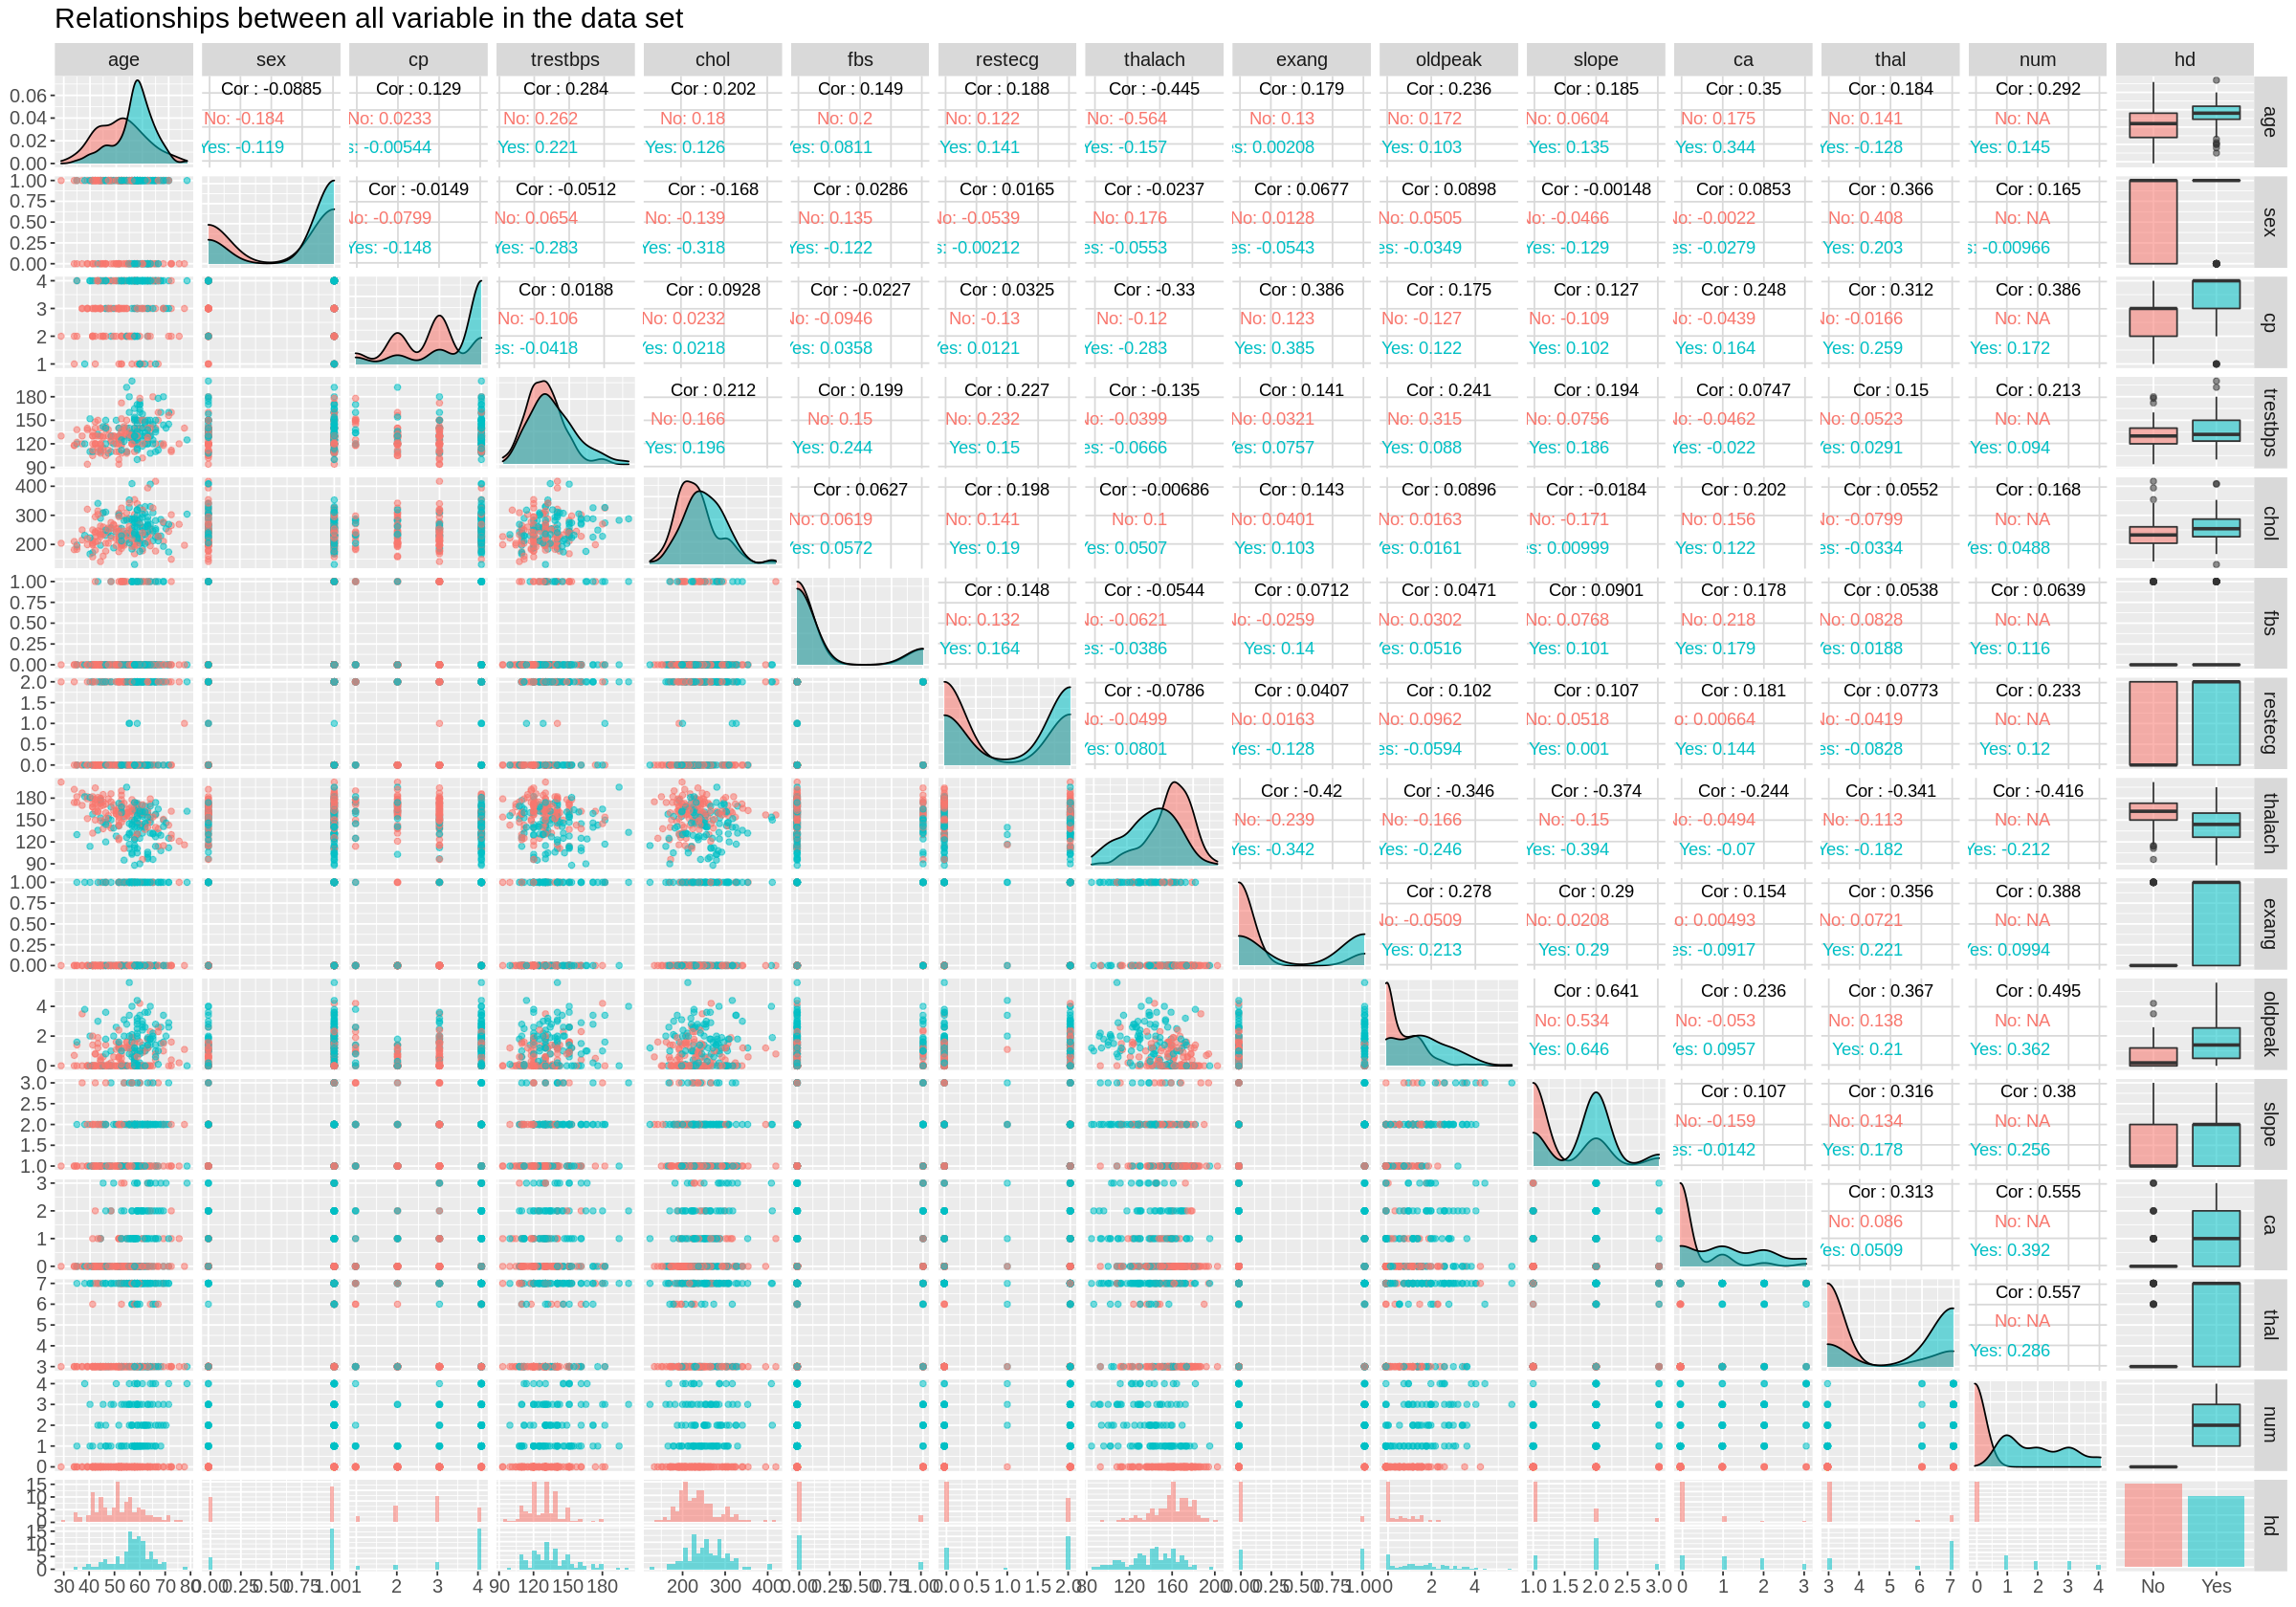

In [79]:
options(repr.plot.width = 20, repr.plot.height = 14)
ggpairs(heart_disease_training, mapping=aes(color=hd, alpha=0.5)) +
    theme(text = element_text(size = 15)) +
    ggtitle("Relationships between all variable in the data set")

Figure 1: Plot comparing all values in the dataset

### Predictors
We first decided to eliminate predictors that are categorical as opposed to quantitative as they would not work with a K-nearest neighbour model. When finding the nearest neighbours in K-nearest neighbour classification, we need to calculate the Euclidean distance for every predictive variable for the data point. For numerical variables, the values can be standardized so the distances for each variable have an equal weight. However with categorical data, there isn’t a standardized distance between the categories that we can use to compute a distance. We also eliminated predictors with missing data.

This eliminated the predictors sex, chest pain type, fasting blood sugar, resting electrocardiographic results, exercise induced angina ST depression induced by exercise relative to rest, slope of peak exercise ST segment, and thalassemia range.

For our model, we will only be using the predictors age, cholesterol level, maximum heart rate achieved, resting blood pressure, and number of major vessels colored by fluoroscopy.

Age: We chose age as a predictor because with increasing age, comes changes in the heart's function, structure, cells and molecules. This makes age the largest risk factor for heart disease (Steenman, M., & Lande, G.). A few other reasons why we chose age was because it was a quantitative predictor and when using ggpairs we found age to be a strong predictor. We identified the strength of each predictor by evaluating distinctions/seperations of points when looking at the ggpairs plots, with the most separated densities of points indicating the strongest correlations and therefore strong predictors to be used in our k-nn classification model.

High blood pressure (systolic pressure: 140 mmHg or higher; diastolic pressure: 90 mmHg or higher) is a risk factor for coronary artery disease, heart attacks, and heart failures. Research points out that high blood pressure causes strain on arteries causing them to deform or narrow. Overtime, a deformed or narrowed artery will cause under-supply of blood to the heart which results in a number of heart related malfunctions. For this reason, we think including patients’ blood pressure in our analysis is meaningful as past literature have repeatedly shown its close association with heart disease risk.

Cholesterol levels: High cholesterol is a commonly known contributor to heart disease. Excessive lipids (fat) can build up in your arteries which can block blood and oxygen flow to the heart (Cleveland Clinic Staff). Like the predictor age, cholesterol is also a quantitative predictor which showed distinct separations between the presence of heart disease and the absence of heart disease when using ggpairs.

Heart rate has been studied extensively in epidemiological studies. Past studies have consistently found that an increase in heart rate is associated with an increase in the risk of heart attack. Heart rate data is also proven to be especially predictive for a number of heart disease onset for older adults. Given our data set is mainly composed of elderly adults and the strong association between heart rate and heart disease, we think it would be relevant to include heart rate in our analysis.

Number of major vessels colored by fluoroscopy: Fluoroscopy is used to image and see the flow of blood through blood vessels by continuously X-raying the patient and adding a contrasting dye into the bloodstream. When the major vessels are colored, it means there is something restricting the flow through of blood. Fluoroscopic analysis has been found to be an early predictor of cardiovascular disease (Gavit et al., 2007).

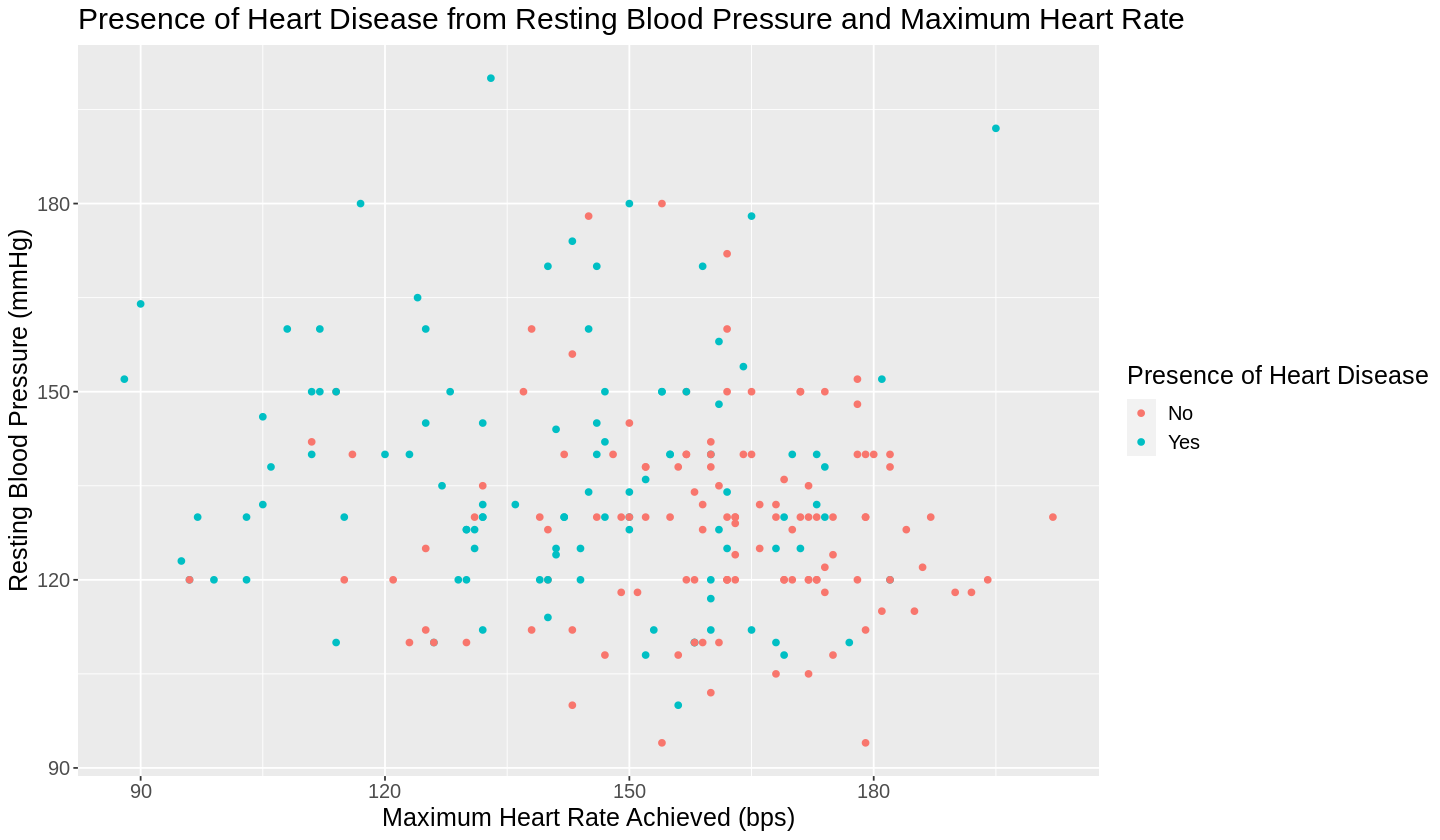

In [80]:
# Graph visualizing the relationship between some predictor values and the presence of heart disease
options(repr.plot.width = 12, repr.plot.height = 7)
heart_disease_plot <- ggplot(heart_disease_training, aes(x=thalach, y=trestbps, color=hd)) +
    geom_point() +
    labs(x="Maximum Heart Rate Achieved (bps)", y="Resting Blood Pressure (mmHg)", color="Presence of Heart Disease") +
    ggtitle("Presence of Heart Disease from Resting Blood Pressure and Maximum Heart Rate") +
    theme(text = element_text(size = 15))
heart_disease_plot

Figure 2: Example relationship from ggpairs. Scatter plot showing heart rate versus blood pressure for training set

We preprocessed the data using the recipe framework to standardize our predictors in our training data.

In [81]:
heart_disease_recipe <- recipe(hd ~ age + trestbps + chol + thalach + ca, data=heart_disease_training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

We first divided the training data into 5 folds with each fold having 80% of the data as training set and 20% as validation set and named it `heart_disease_vfold`. We then use the `tune_grid` function to train our classifier on each fold’s training data set and evaluating model performance on each fold’s validation data set for each value of neighbours (k from 1 to 15). Finally, we retrieved model performance metrics and named the object `knn_results`. 
 
We determined our model prediction accuracy for each k value and arranged the prediction accuracy in a descending order. 

In [82]:
knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_training, v=5, strata=hd)

knn_results <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = heart_disease_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7714141,5,0.03096236,Model02
7,accuracy,binary,0.7581818,5,0.04123062,Model05
8,accuracy,binary,0.7581818,5,0.04123062,Model06
11,accuracy,binary,0.7581818,5,0.03543332,Model09
12,accuracy,binary,0.7581818,5,0.03543332,Model10
5,accuracy,binary,0.7535354,5,0.03650820,Model03


Table 3: Predictive accuracy using cross-validation for different values of k

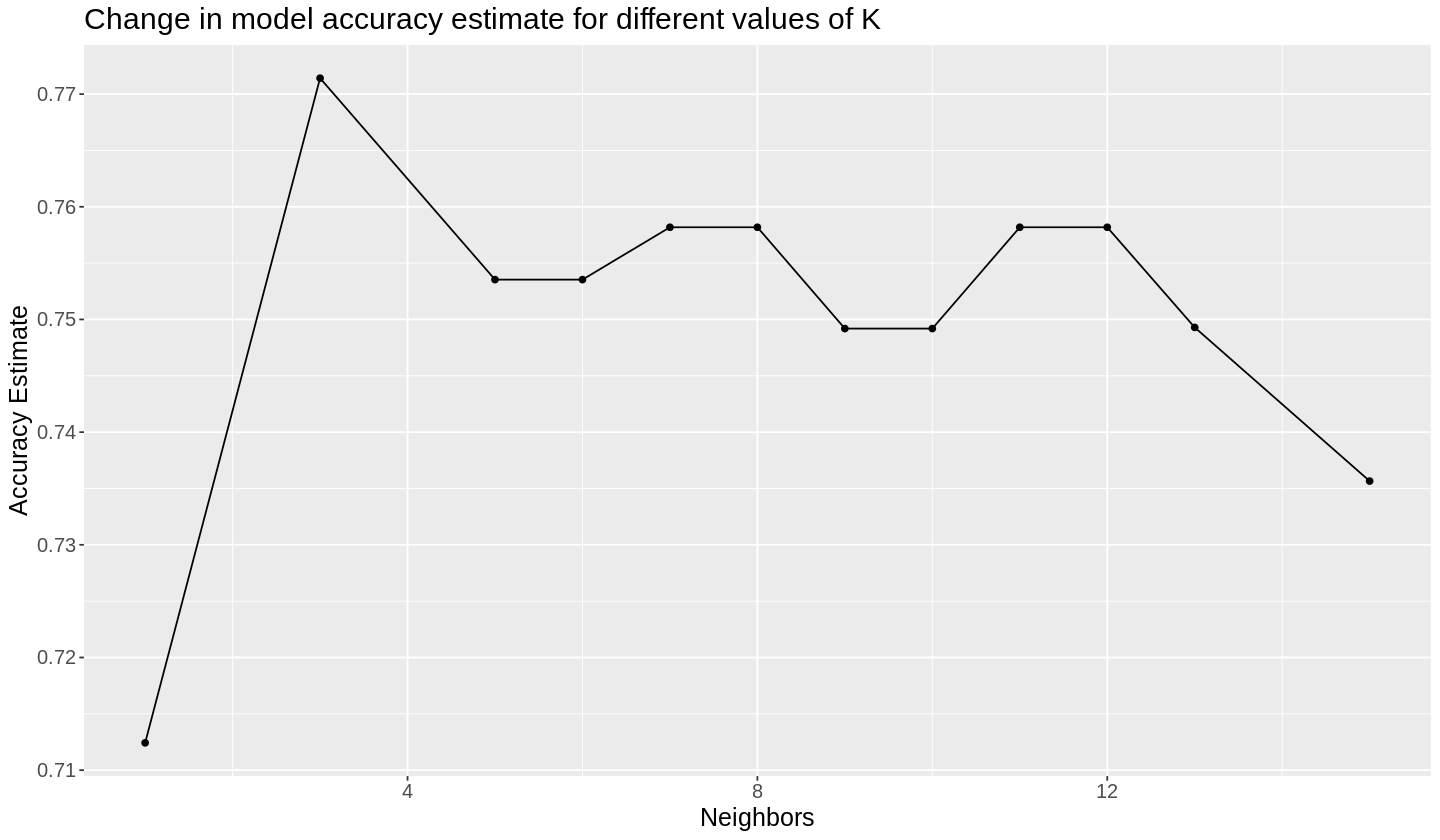

In [83]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Change in model accuracy estimate for different values of K") +
    theme(text = element_text(size = 15))
accuracy_versus_k

Figure 3: Graph of k neighbours to predictive accuracy estimate using cross validation

We chose to go with a value of 3 for k because it produces the highest average accuracy over the training set using cross-validation. Because we are using cross-validation, the effects of over-fitting should be mitigated by the folds on the training set.

We retrained our model using our new value for k and created a fit object `heart_disease_fit` which holds our model, recipe, and training set to be used in predictions.

In [99]:
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=3) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_disease_fit <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_spec) %>%
    fit(data=heart_disease_training)

We pass the fit object and testing data to the `predict()` function in order to make predictions on the Yes/No status of heart disease on our testing data. We then use the `bind_cols()` function to attach these predictions as a column to our testing data.

In [95]:
heart_disease_predictions <- predict(heart_disease_fit, heart_disease_testing) %>%
    bind_cols(heart_disease_testing)

We use our new dataset with predicted status of heart disease and true status of heart disease for our testing data and pass it to the `metrics()` function to get an estimated accuracy for our predictions. We then use `slice()`, `select()`, and `pull()` to get the estimated predictive accuracy as a numerical value.

In [96]:
heart_disease_accuracy <- heart_disease_predictions %>%
        metrics(truth = hd, estimate = .pred_class) %>%
        slice(1) %>%
        select(.estimate) %>%
        pull()

heart_disease_accuracy

[1] 0.7027027

The predictive accuracy for the testing set was found to be 70.3%

We visualize the accuracy of this data using a confusion matrix to see the instances of false positives, false negatives, true positives, and true negatives. 

In [87]:
heart_disease_conf_mat <- heart_disease_predictions %>%
        conf_mat(truth = hd, estimate = .pred_class)

heart_disease_conf_mat

          Truth
Prediction No Yes
       No  28  14
       Yes 12  20

Figure 4: Confusion matrix for the model using the testing set

## Discussion

Using a 5-fold cross-validation process, we have found out that using three neighbours in predicting the heart disease status for patients in the training data yielded the most accuracy, 77.14%. We retrained our classifier with the optimal number of neighbors and fitted the trained model on patients that were randomly assigned to the testing data set. Our heart disease status classifier returned an accuracy level of 70.3%. This accuracy level is higher than the proportion of majority labels, 53.81%, which suggests our classifier is performing above random chance level. Extracting the confusion matrix from our model, we found that 28 out of 40 patients who didn’t have heart disease were correctly classified as negative for heart disease; 20 out of 34 patients who have heart disease were correctly classified as positive for heart disease. This implies our model has a false negative and false positive rate of 30% and 41.2% respectively. 

We expected to find that patients that are older, have a high level of cholesterol, high blood pressure, and higher number of major vessels colored by fluoroscopy are more likely to be diagnosed with heart disease, as they are commonly known contributors to heart disease. We used ggpairs in order to plot the correlations between every predictor and the outcome of presence of heart disease. When doing this, the strongest correlations with the presence or absence of heart disease were that for the predictors age, cholesterol, blood pressure, and number of major vessels colored by fluoroscopy. We identified the strength of correlations by evaluating distinctions/seperations of points when looking at the ggpairs plots, with the most separated densities of points indicating the strongest correlations and therefore strong predictors to be used in our k-nn classification model. However, due to the low accuracy of our model, as well as the relatively high false positives and false negatives, we can not accurately determine if age, cholesterol, blood pressure, and number of major vessels colored by fluoroscopy are strong enough predictors to be used as a sole indicator of heart disease.

We can predict the presence of heart disease of any severity given resting blood pressure, cholesterol level, maximum heart rate, age, and number of vessels colored by fluoroscopy of a patient with a 70.3% accuracy. This model, while certainly not sufficiently accurate to be used in high confidence predictions of heart disease in a medical setting, could give patients an early warning of presence of heart disease with >50% accuracy. This could encourage the patient to see a medical professional and potentially receive early treatment before the disease has a chance to develop further and cause serious complications.

### What future questions could this lead to?
- How strong of a predictor is each individual characteristic for a diagnosis of heart disease? (What is the weight of each predictor?)
- Which characteristics are the best predictors?
- How can we target these characteristics early on in heart disease identification when patients are at a lower risk state?



## Citation

Cleveland Clinic Staff. (2018, December 20). Preventing & reversing cardiovascular disease. Cleveland Clinic. Retrieved December 6, 2021, from https://my.clevelandclinic.org/health/articles/17385-cardiovascular-disease-prevention--reversal.

Gavit, L., Carlier, S., Hayase, M., Burkhoff, D., & Leon, M. B. (2007). The evolving role of coronary angiography and fluoroscopy in cardiac diagnosis and intervention. 
EuroIntervension, 2007;2. Retrieved December 5, 2021, from https://www.researchgate.net/profile/Stephane-Carlier/publication/26813142_The_evolving_role_of_coronary_angiography_and_fluoroscopy_in_cardiac_diagnosis_and_intervention/links/0c96052fb908bc76b7000000/The-evolving-role-of-coronary-angiography-and-fluoroscopy-in-cardiac-diagnosis-and-intervention.pdf

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988, July 1). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved November 4, 2021, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease.

Mayo Clinic . (2019, November 19). How high blood pressure can affect your body. Mayo Clinic. Retrieved December 7, 2021, from https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/high-blood-pressure/art-20045868

Mayo Clinic Staff. (2021, February 9). Heart disease. Mayo Clinic. Retrieved November 9, 2021, from https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118.

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in cardiovascular diseases, 52(1), 6–10. Retrieved December 4, 2021, from https://doi.org/10.1016/j.pcad.2009.05.003.

Steenman, M., & Lande, G. (2017, March 20). Cardiac aging and heart disease in humans - biophysical reviews. SpringerLink. Retrieved December 5, 2021, from https://link.springer.com/article/10.1007/s12551-017-0255-9.

This data was collected by the following principal investigators for data collection at each institution:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D.

